# GY521

 GY521 is installed on RaspberryPi 
 
        

## A first test on GY521

<ul>
    <li> <a href="gy521Emitterpy">gy521Emitter.py</a>: reads GY521 and emits (via MQTT) the event:
        
<tt>msg(g521,event,rasp,none,g521(TYPE,X,Y,Z),N)</tt>
        
The events can be plotted by using <a href="mqttPlotQakEventspy">mqttPlotQakEvents.py</a>.</li>
</ul>

#### <a name="firsttest">First test: Hands on</a>
<ol>
    <li>On the RaspberryPi: launch <a href="gy521Emitterpy">gy521Emitter.py</a> </li>
    <li>On the PC: launch <a href="mqttPlotQakEventspy">mqttPlotQakEvents.py</a></li>    
</ol>

For a more useful application, see <a href="#rotate90">Rotate 90</a>.
 
        

### <a name="gy521emitterpy">gy521emitter</a>   

In [ ]:
"""
gy521emitter.py
----------------------------------------------
RUN ON THE RASPBERRYPI
"""
import smbus
import math
import time
import paho.mqtt.client as paho
#from mpu6050 import mpu 

brokerAddr ="192.168.1.7"
tsleep     = 0.2
ndatasec   = 1.0 / tsleep
emitTime   = 60  						#sec
maxnum     = int(ndatasec)*emitTime
count      = 0

sensor     = mympu6050(0x68)

def sendMsg( client,x,y,z, sensorType ) :
	global count
	count = count + 1
	#msg(sensor,event,gyroSender,none,sensor(TYPE,X,Y,Z),MSGNUM)
	template = "msg(g521,event,rasp,none,g521({0},{1},{2},{3}),{4})"
	msgout   = template.format(sensorType, x,y,z,count)
	print("SEND-MQTT: " + msgout )
	client.publish("unibo/qak/events", msgout, 0, retain=False);

def emitAccel(client) :	
	global sensor
	scale = 16384.0
	accelerometer_data = sensor.get_accel_data()
	x = accelerometer_data['x']
	y = accelerometer_data['y']
	z = accelerometer_data['z']
	#print accelerometer_data 	 
 	sendMsg(client,x,y,z,"accel" )

def emitGyro(client) :	
	global sensor
	scale = 131.0
	gyro_data = sensor.get_gyro_data()
	x = gyro_data['x']
	y = gyro_data['y']
	z = gyro_data['z']
	#print gyro_data 	 
 	sendMsg(client,x,y,z,"gyro" )

def doAccel() :
	print "Accelerometer "
	print "---------------------"
	for i in range(1, maxnum) :
		emitAccel(client) 
		time.sleep(tsleep)
def doGyro() :
	maxnum = 30
	print "Gyroscope"
	print "--------"	
	for i in range(1, maxnum) :
		emitGyro(client) 
		time.sleep(tsleep) 


print( __name__ )
print sensor

client= paho.Client("g521emitter")      
client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)
startTime     = time.time() 
#print( "startTime=" , time.localtime( startTime ) )
print( "startTime=" , startTime )

#doAccel()
doGyro()

### <a name="mqttPlotQakEventspy">mqttPlotQakEvents.py</a>    

In [ ]:
"""
mqttPlotQakEvents.py
Events DO NOT include the angle 
msg(g521,event, gyroSender, none, g521(TYPE,X,Y,Z),MSGNUM)
"""
import time
import paho.mqtt.client as paho
import matplotlib.pyplot as plt

brokerAddr="localhost"
duration = 10
x        = []
y        = []
z        = []
goon     = True
msgnum   = 0

def on_message(client, userdata, message) :   #define callback
	global msgnum,  x,y,z, goon
	if not goon :
		return
	#msg(androidSensor,event,android,none,androidSensor(TYPE,X,Y,Z),MSGNUM)
    #msg(g521,event, gyroSender, none, g521(TYPE,X,Y,Z),MSGNUM)
	evMsg = str( message.payload.decode("utf-8")  )
	msgitems = evMsg.split(",")
	if msgnum < 30  :
		#print("evMsg=", evMsg, "msgnum=", msgnum )
		msgnum = msgnum + 1
		x.append( float( msgitems[5] ) )
		y.append( float( msgitems[6] ) )
		vz = float( msgitems[7].split(')')[0] )
		z.append( vz )
	else  :
		print("evMsg=", evMsg, "msgnum=", msgnum )
		plt.plot(list(x), color='red')
		plt.plot(list(y), color='green')
		plt.plot(list(z), color='blue')
		plt.show()
		goon = False
		client.disconnect()
    
client= paho.Client("mqttPlotQakEvents")      
client.on_message=on_message            # Bind function to callback

client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)
print("subscribing to unibo/qak/events")
client.subscribe("unibo/qak/events")      #subscribe

print("collecting values; please wait ..." )
client.loop_start()             #start loop to process received messages
time.sleep(duration)
client.disconnect()             #disconnect
print("bye")
client.loop_stop()              #stop loop        


## <a name="rotate90">Rotate of 90°</a> 

<ul>
    <li> <a href="#moveRobotpy">moveRobot.py</a>: waits for a command (<tt>r|l</tt>), and:
        <ul>
            <li>executes the command</li>
            <li>evalutes the rotation angle by using the <i>gyroscope</i></li>
            <li>if it is the case, add some move to reach <tt>90°</tt></li>
            <li>writes data on the file <b>dataRot.txt</b></li>
            <li>emits (via MQTT) the event <tt>msg(g521,event,rasp,none,g521(TYPE,X,Y,Z,ANGLE),N)</tt></li>
        </ul>
        The move commands can be sent by using <a href="#rotSenderpy">rotSender.py</a>.  
        The events can be plotted by using <a href="#plotGY521py">PlotGY521.py</a>.
    </li>
</ul>

#### <a name="rot90">Rotate 90: Hands on</a>
<ol>
    <li>On the RaspberryPi: launch <a href="#moveRobotpy">moveRobot.py</a> </li>
    <li>On the PC: launch <a href="#plotGY521py">PlotGY521.py</a></li>
    <li>On the PC: launch  <a href="#rotSenderpy">rotSender.py</a> to rotate of 90° r and 90° l</li>
    <li>Check that the robot is back in the original position </li>
    
</ol>

### <a name="moveRobotpy">moveRobot.py</a>   

In [ ]:
"""
moveRobot.py
----------------------------------------------
RUN ON THE RASPBERRYPI
"""
import smbus
import math
import time
import paho.mqtt.client as paho
import serial

brokerAddr ="192.168.1.7"
tsleep     = 0.1
ndatasec   = 1.0 / tsleep
emitTime   = 3  				#sec
maxnum     = 20 				#int(ndatasec)*emitTime
count      = 0
startTime  = 0
oldangle    = 0.0
angle      = 0.0 
duration   = 30

lowAngle  = 88.0
highAngle = 92.5        

dataFile          = open("dataRot.txt", "a")

sensor = mympu6050(0x68)

def on_message(client, userdata, message) :  
	global angle 
	evMsg = str( message.payload.decode("utf-8")  )
	#msg(rotationCmd,event, SENDER, none, rotationCmd(CMD),MSGNUM)
	msgitems = evMsg.split(",")
	if msgitems[0] == "msg(g521" :
		return
	if msgitems[0] == "endofjob" :
		sendMsg(client,'endofjob',0,0,0,0)
		return
	print "evMsg=", evMsg 
	CMD      = msgitems[4].split('(')[1].split(')')[0] 
	#print "CMD=", CMD 
	angle = 0.0
	if CMD == 'r' or CMD == 'l'  :
		doGyro(CMD)
	if  CMD == 'x' or CMD == 'z' :
		doGyroStep(CMD)
	

ser = serial.Serial(
	port='/dev/ttyUSB0', 
	baudrate=115200,             
	parity=serial.PARITY_NONE,
	stopbits=serial.STOPBITS_ONE,
	bytesize=serial.EIGHTBITS,
	timeout=1 )

def sendMsg( client,x,y,z,angle,sensorType ) :
	global count 
	count = count + 1
	#msg(sensor,event,gyroSender,none,sensor(TYPE,X,Y,Z,ANGLE),MSGNUM)	  				
	template = "msg(g521,event,rasp,none,g521({0},{1},{2},{3},{4}),{5})"
	msgout   = template.format(sensorType, x,y,z,angle,count)
	print "SEND-MQTT: " + msgout  
	client.publish("unibo/qak/events", msgout, 0, retain=False);		

def doGyro(CMD) :
	global angle , dataFile, lowAngle, highAngle
	#evalAngle(CMD)
	#oldangle = angle
	ser.write(CMD+'\n')		#EXECUTE THE COMMAND
	evalAngle(CMD)
	oldangle = angle
	evalAngle(CMD)
	da = abs( angle - oldangle )
	while da > 0.7 :
		oldangle = angle
		evalAngle(CMD)
		da = abs( angle - oldangle )	 
	print "FIRST STEP CMD=", CMD , " DONE angle=" , angle	
	template = "FIRST STEP DONE CMD={0} ANGLE={1} \n"
	dataFile.write( template.format(CMD,angle) )
	dataFile.flush()
	if  angle  > lowAngle and  angle < highAngle :
		print "ROTATION DONE" 
	else : 
		compensate( CMD )
	angle = 0.0
	

def doGyroStep( CMD ) :
	global angle 	
	evalAngle(CMD)
	startangle = angle
	ser.write(CMD+'\n')
	evalAngle(CMD)
	print "doGyroStep angle=" , angle , " angle corrected= ", angle-startangle	
	
def compensate( CMD ) :
	global angle, dataFile, lowAngle, highAngle
 	print " ----------------------------------- compensate START:" , CMD, " angle=" , angle
 	if CMD == 'r' :	
 		if  angle  < lowAngle :
 			ser.write('x\n')
 			evalAngle('r', "compensate")
 		if  angle  > highAngle :
 			ser.write('l\n')
 			evalAngle('l', "compensate")
  	if CMD == 'l' :	
 		if angle < lowAngle :
 			ser.write('l\n')
 			evalAngle('l', "compensate")
  		if angle > highAngle :
 			ser.write('x\n')	
 			evalAngle('r', "compensate")
 	print " ----------------------------------- compensate END :" , CMD, " angle=" , angle
	template = "COMPENSATE CMD={0} ANGLE={1} \n"
	dataFile.write( template.format(CMD, angle) )
 	dataFile.flush()
	print "COMPENSATE STEP angle=" , angle	
	
 
def evalAngle(CMD, mode="direct") :		# mode = "direct" or "compensate"
	global angle, tsleep, client
	data = sensor.get_gyro_data()
	x  = data['x']
	y  = data['y']
	z  = data['z']
	da = 0
	sendMsg( client,x,y,z,angle, "gyro" ) 	#events arrive at this app too!!!
	if ( CMD == 'r'  ) and z < 0 :
		da    = abs(z) * tsleep
		if mode == "compensate" :
			da  = - da 
	if ( CMD == 'l'  ) and z > 0 :
		da    = z * tsleep
		if mode == "compensate" :
			da  = -da
	angle = angle + da 
	print "evalAngle: ", angle , " z= " , z , " CMD=" , CMD, "mode=" , mode
	time.sleep(tsleep) 

client= paho.Client("moveRobot")  
client.on_message=on_message            # Bind function to callback    

client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)
startTime     = time.time() 
#print( "startTime=" , time.localtime( startTime ) )
print( "startTime=" , startTime )

print("subscribing to unibo/qak/events")
client.subscribe("unibo/qak/events")      #subscribe



print("collecting values; please wait ..." )
client.loop_start()             #start loop to process received messages
dataFile.write("START JOB \n")
time.sleep(duration)
dataFile.close()
client.disconnect()             #disconnect
print("bye")
client.loop_stop()              #stop loop    

### <a name="rotSenderpy">rotSender.py</a>  

In [ ]:
"""
rotSender.py
"""
import paho.mqtt.client as paho
import time

brokerAddr ="localhost"

def sendMsg( client,CMD ) :
	#msg(rotationCmd,event,gyroSender,none,rotationCmd(CMD),MSGNUM)	  
	msgout   = "msg(rotationCmd,event,source,none,rotationCmd("+ CMD +"))"
	print("SEND: " + msgout )
	client.publish("unibo/qak/events", msgout, 0, retain=False);

client= paho.Client("utilGY521")      
client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)

time.sleep(1)
sendMsg( client, 'l') 
time.sleep(2)
sendMsg( client, 'r')
time.sleep(2)
sendMsg( client, 'l')
time.sleep(2)
sendMsg( client, 'r')
print( "bye " )

### <a name="plotGY521py">plotGY521.py</a>      

connected to broker  localhost
subscribing to unibo/qak/events
collecting values; please wait ...


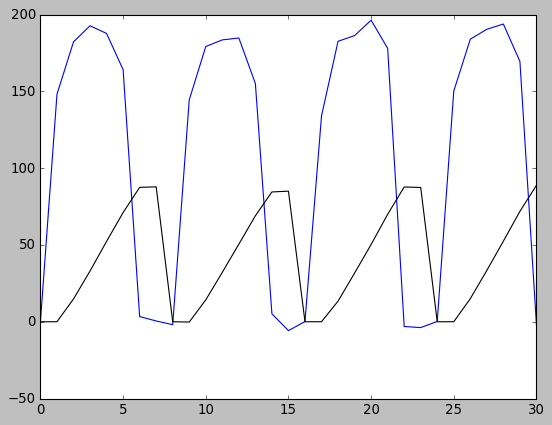

bye


In [2]:
"""
plotGY521.py
Events include the angle 
msg(g521,event, gyroSender, none, g521(TYPE,X,Y,Z,ANGLE),MSGNUM)
"""
import time
import paho.mqtt.client as paho
import matplotlib.pyplot as plt

brokerAddr="localhost"
duration = 20
x        = []
y        = []
z        = []
a        = []
msgnum   = 0
angle    = 0

def on_message(client, userdata, message) :   #define callback
	global msgnum, x,y,z, angle
	#msg(androidSensor,event,android,none,androidSensor(TYPE,X,Y,Z),MSGNUM)
    #msg(g521,event, gyroSender, none, g521(TYPE,X,Y,Z,ANGLE),MSGNUM)
    #msg(rotationCmd,event,gyroSender,none,rotationCmd(CMD),MSGNUM)
	evMsg = str( message.payload.decode("utf-8")  )
	#print( evMsg )
	msgitems = evMsg.split(",")
	cmd = msgitems[4].split('(')[1].split(')')[0]
	#print( cmd )

	if cmd == "showangle" :
		print( "FINAL angle=" , ("%.3f" % angle), "msgnum=", msgnum )
        
	if cmd == "endofjob" :  #else is gyro
		#plt.plot(list(x), color='red')
		#plt.plot(list(y), color='green')
		plt.plot(list(z), color='blue')
		plt.plot(list(a), color='black')
		plt.show()
		time.sleep(1)
		client.disconnect()
		return        
	x.append( float( msgitems[5] ) )
	y.append( float( msgitems[6] ) )
	vz = float( msgitems[7] )
	z.append( vz )
	angle = float( msgitems[8].split(')')[0] )
	a.append( angle )
	msgnum = msgnum + 1
	#print( "z=", vz, "angle=" , angle, "msgnum=", msgnum )

plt.style.use("classic")
client= paho.Client("receiver")      
client.on_message=on_message            # Bind function to callback

client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)
print("subscribing to unibo/qak/events")
client.subscribe("unibo/qak/events")      #subscribe

print("collecting values; please wait ..." )
msgnum   = 0
client.loop_start()             #start loop to process received messages
time.sleep(duration)
client.disconnect()             #disconnect
print("bye")
client.loop_stop()              #stop loop        



START JOB 2019-08-22 21:41:34.348294
z=0.351145038168 ANGLE=0.0351145038168 mode=direct da=0.0351145038168
z=138.374045802 ANGLE=13.872519084 mode=direct da=13.8374045802
z=176.511450382 ANGLE=31.5236641221 mode=direct da=17.6511450382
z=190.0 ANGLE=50.5236641221 mode=direct da=19.0
z=180.389312977 ANGLE=68.5625954198 mode=direct da=18.0389312977
z=164.198473282 ANGLE=84.9824427481 mode=direct da=16.4198473282
z=-5.68702290076 ANGLE=84.9824427481 mode=direct da=0.0

FIRST STEP DONE CMD=l ANGLE=84.9824427481
z=-2.80152671756 ANGLE=84.9824427481 mode=compensate da=0.0
COMPENSATE CMD=l ANGLE=84.9824427481

z=0.106870229008 ANGLE=0.0106870229008 mode=direct da=0.0106870229008
z=138.824427481 ANGLE=13.893129771 mode=direct da=13.8824427481
z=181.06870229 ANGLE=32.0 mode=direct da=18.106870229
z=189.007633588 ANGLE=50.9007633588 mode=direct da=18.9007633588
z=185.687022901 ANGLE=69.4694656489 mode=direct da=18.5687022901
z=166.618320611 ANGLE=86.1312977099 mode=direct da=16.6618320611
z=0.152671755725 ANGLE=86.1465648855 mode=direct da=0.0152671755725

FIRST STEP DONE CMD=l ANGLE=86.1465648855
z=-6.00763358779 ANGLE=86.1465648855 mode=compensate da=0.0
COMPENSATE CMD=l ANGLE=86.1465648855

z=0.129770992366 ANGLE=0.0129770992366 mode=direct da=0.0129770992366
z=142.473282443 ANGLE=14.2603053435 mode=direct da=14.2473282443
z=177.030534351 ANGLE=31.9633587786 mode=direct da=17.7030534351
z=183.801526718 ANGLE=50.3435114504 mode=direct da=18.3801526718
z=195.290076336 ANGLE=69.872519084 mode=direct da=19.5290076336
z=179.022900763 ANGLE=87.7748091603 mode=direct da=17.9022900763
z=-4.36641221374 ANGLE=87.7748091603 mode=direct da=0.0

FIRST STEP DONE CMD=l ANGLE=87.7748091603
z=-2.57251908397 ANGLE=87.7748091603 mode=compensate da=0.0
COMPENSATE CMD=l ANGLE=87.7748091603

z=0.343511450382 ANGLE=0.0343511450382 mode=direct da=0.0343511450382
z=147.503816794 ANGLE=14.7847328244 mode=direct da=14.7503816794
z=181.58778626 ANGLE=32.9435114504 mode=direct da=18.158778626
z=179.229007634 ANGLE=50.8664122137 mode=direct da=17.9229007634
z=186.580152672 ANGLE=69.5244274809 mode=direct da=18.6580152672
z=161.114503817 ANGLE=85.6358778626 mode=direct da=16.1114503817
z=-0.198473282443 ANGLE=85.6358778626 mode=direct da=0.0

FIRST STEP DONE CMD=l ANGLE=85.6358778626
z=-3.35877862595 ANGLE=85.6358778626 mode=compensate da=0.0
COMPENSATE CMD=l ANGLE=85.6358778626
